# Carvana Image Masking Challenge

Code for the solution in Kaggle's Carvana Image Masking Challenge on car segmentation (https://www.kaggle.com/c/carvana-image-masking-challenge).

We used U-Net to segment a car in the image. This Blogpost explaining the solution: https://www.novatec-gmbh.de/blog/semantic-segmentation-part-2-training-u-net/

## Requirements

To train the final model we used the following hardware and software:

- OS: Ubuntu 18.04 Server
- Hardware: CPU Intel Core i7-7700k 64 Gb Ram
- Required hardware: Any decent modern computer with x86-64 CPU, minimum 32 GB RAM
- Powerful GPU

Main software for training neural networks:
- Python 3.5
- CUDA 
- Tensorflow-GPU and Tensorflow, Keras

Data:

Generate the required data paths in '\data' and put in the datasets you downloaded on the Kaggle website.



# Load Libraries


In [22]:
import os
import time
import h5py
import math
import pickle
import numpy as np
import pandas as pd
import cv2
import threading
import queue
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import misc, ndimage
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
from skimage import transform
from tqdm import tqdm
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.losses import binary_crossentropy
import keras.backend.tensorflow_backend as KTF
from keras import utils as ku
import tensorflow as tf
from tensorflow.python.client import device_lib

import imageio

%matplotlib inline

# Check GPU usage

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12512097892878715693
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3146173644
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3148304806326520422
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Define data paths

In [3]:
DATA_PATH = 'data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_MASKS_PATH = os.path.join(DATA_PATH, 'train_masks')
TRAIN_MASKS_CSV_PATH = os.path.join(DATA_PATH, 'train_masks.csv')
SAMPLE_SUBMISSION_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')
METADATA_PATH = os.path.join(DATA_PATH, 'metadata.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')
TENSORBOARD_PATH = os.path.join(DATA_PATH, 'tensorboard')

# Mask shape

In [4]:
train_masks_df = pd.read_csv(TRAIN_MASKS_CSV_PATH)
print('train_masks_df.shape', train_masks_df.shape)
train_masks_df.head()

train_masks_df.shape (5088, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


# Define methods and constants

In [5]:
# Constants
HEIGHT_ORIG = 1280
WIDTH_ORIG = 1918
CHANNELS_ORIG = 3

HEIGHT = 512
WIDTH = 512
CHANNELS = 3
new_shape = (WIDTH, HEIGHT, CHANNELS)
mask_shape = (new_shape[0], new_shape[1], 1)

def get_img_id(img_path):
    return img_path[:15]

img_ids = list(map(get_img_id, list(train_masks_df.img.values)))

def load_image_disk(img_id, folder=TRAIN_PATH):
    img = imageio.imread(os.path.join(folder, img_id + ".jpg"))
    return img

def get_image(img_id):
    return train_imgs[img_id]

# Return mask as 1/0 binary img with single channel
def load_mask_disk(img_id, folder=TRAIN_MASKS_PATH, filetype='gif'):
    mask = imageio.imread(os.path.join(folder,  "{}_mask.{}".format(img_id, filetype)))#, as_gray=True)
    mask[mask > 128] = 1
    if len(mask.shape) == 2:
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
    return mask

def get_mask(img_id):
    return train_masks[img_id]

# Helper functions to plot car, mask, masked_car
def plot_image(img_id):
    img = imageio.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def plot_mask(img_id, folder=TRAIN_MASKS_PATH, filetype='gif', ax=None):
    mask = imageio.imread(os.path.join(folder, "{}_mask.{}".format(img_id, filetype)))
    if ax == None:
        imgplot = plt.imshow(mask)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(mask)
        ax.axis('off')
    
def plot_masked_image(img_id, ax=None):
    img = imageio.imread(os.path.join(TRAIN_PATH, img_id + ".jpg"))
    mask = imageio.imread(os.path.join(TRAIN_MASKS_PATH, img_id + "_mask.gif"))
    mask = mask[:,:,0:3]
    mask[mask == 255] = 1 
    masked_img = img * mask
    if ax == None:
        imgplot = plt.imshow(masked_img)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(masked_img)
        ax.axis('off')

def gray2rgb(img):
    img = np.squeeze(img)
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = img
    ret[:, :, 1] = img
    ret[:, :, 2] = img
    return ret

def resize_img(img, new_s = new_shape):
    return transform.resize(img, new_s)

# Read images and masks into memory

In [6]:
# Read training images into memory
train_imgs = {}
for img_path in tqdm(os.listdir(TRAIN_PATH)):
    img_id = get_img_id(img_path)
    train_imgs[img_id] = cv2.resize(load_image_disk(img_id), (new_shape[0], new_shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████| 5088/5088 [02:41<00:00, 31.47it/s]


In [7]:
# Read training masks into memory
train_masks = {}
for img_path in tqdm(os.listdir(TRAIN_MASKS_PATH)):
    img_id = get_img_id(img_path)
    train_masks[img_id] = np.expand_dims(cv2.resize(load_mask_disk(img_id), (new_shape[0], new_shape[1])), axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 5088/5088 [02:44<00:00, 30.88it/s]


# Define Data Augmentation methods

In [8]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT_101, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(0, 0, 0,))
        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=2)

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

# Define methods for batch generation

In [23]:
def generate_training_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            x, y = randomShiftScaleRotate(x, y,
                                          shift_limit=(-0.0625, 0.0625),
                                          scale_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
            x = randomHueSaturationValue(x,
                                hue_shift_limit=(-50, 50),
                                sat_shift_limit=(-5, 5),
                                val_shift_limit=(-15, 15))
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        #Y = np.asarray(Y_batch, dtype=np.float32)
        Y = ku.to_categorical(Y_batch, 2)
        yield X, Y

def generate_validation_batch(data, batch_size):
    while True:
        X_batch = []
        Y_batch = []
        batch_ids = np.random.choice(data,
                                     size=batch_size,
                                     replace=False)
        for idx, img_id in enumerate(batch_ids):
            x = get_image(img_id)
            y = get_mask(img_id)
            X_batch.append(x)
            Y_batch.append(y)
        X = np.asarray(X_batch, dtype=np.float32)
        ##Y = np.asarray(Y_batch, dtype=np.float32)
        Y = ku.to_categorical(Y_batch, 2)
        yield X, Y

def generate_validation_data_seq(data):
    idx = 0
    while True:
        img_id = data[idx]
        X = get_image(img_id)
        Y = get_mask(img_id)
        yield img_id, X, Y
        idx  += 1
        if idx >= len(data):
            break

def get_model_memory_usage(batch_size, model):
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

    total_memory = 4*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = round(total_memory / (1024 ** 3), 3)
    mbytes = round(total_memory / (1024 ** 2), 3)
    
    print('trainable_count', trainable_count, 'non_trainable_count', non_trainable_count, 'gbytes', gbytes, 'mbytes', mbytes)

# Impact of random shift scale rotate

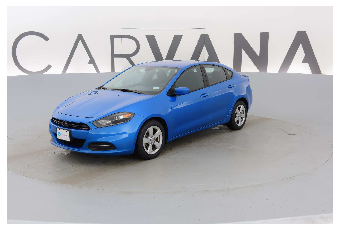

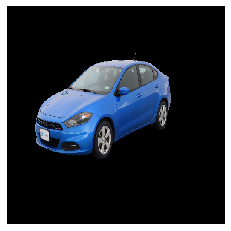

In [10]:
# Visualize impact of random shift scale rotate
random_idx = np.random.randint(len(train_imgs.keys()))
random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = get_image(random_img_id)
mask = get_mask(random_img_id)
temp_img, temp_mask = randomShiftScaleRotate(temp_img, mask,
                              shift_limit=(-0.0625, 0.0625),
                              scale_limit=(-0.1, 0.1),
                              rotate_limit=(-0, 0))

plt.imshow(temp_img * gray2rgb(temp_mask))
plt.axis('off')
plt.show()

# Impact of random hue saturation

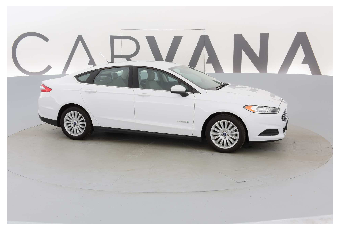

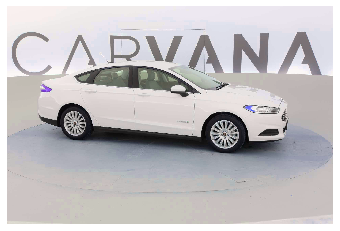

In [11]:
# Visualize impact of random hue saturation
random_idx = np.random.randint(len(train_imgs.keys()))
random_img_id = list(train_imgs.keys())[random_idx]
plot_image(random_img_id)
temp_img = cv2.imread(os.path.join(TRAIN_PATH, '{}.jpg'.format(random_img_id)))
temp_img = randomHueSaturationValue(temp_img,
                               hue_shift_limit=(-50, 50),
                               sat_shift_limit=(-5, 5),
                               val_shift_limit=(-15, 15))
plt.imshow(temp_img)
plt.axis('off')
plt.show()

# Define U-Net model

In [12]:
def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

In [13]:
def get_unet_1024(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=2):
    inputs = Input(shape=input_shape)

    with tf.device('/gpu:0'):
        #down0b, down0b_res = down(8, inputs)
        down0a, down0a_res = down(24, inputs)
        down0, down0_res = down(64, down0a)
        down1, down1_res = down(128, down0)
        down2, down2_res = down(256, down1)
        down3, down3_res = down(512, down2)
        down4, down4_res = down(768, down3)

        center = Conv2D(768, (3, 3), padding='same')(down4)
        center = BatchNormalization(epsilon=1e-4)(center)
        center = Activation('relu')(center)
        
    with tf.device('/gpu:1'):
        center = Conv2D(768, (3, 3), padding='same')(center)
        center = BatchNormalization(epsilon=1e-4)(center)
        center = Activation('relu')(center)

        up4 = up(768, center, down4_res)
        up3 = up(512, up4, down3_res)
        up2 = up(256, up3, down2_res)
        up1 = up(128, up2, down1_res)
        up0 = up(64, up1, down0_res)
        up0a = up(24, up0, down0a_res)
        #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model

In [12]:
# Build U-Net model
def get_unet_1024(input_shape=(HEIGHT, WIDTH, CHANNELS), num_classes=1):
    #inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    inputs = Input(shape=input_shape)
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    #model.summary()
    
    return model    

# Define Dice Coef evaluation

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [15]:
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_coef(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score

def weighted_dice_loss(y_true, y_pred, weight):
    return 1. - weighted_dice_coef(y_true, y_pred, weight)

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.01), 'float32') * K.cast(K.less(averaged_mask, 0.99), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + weighted_dice_loss(y_true, y_pred, weight)
    return loss

# Train the model

In [16]:
BATCH_SIZE = 1
# Training new model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 30
steps_per_epoch = int(len(img_ids) * 0.8/BATCH_SIZE)
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH,'model-1555053470.h5')

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              min_delta = 0.0001,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = get_unet_1024()
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])
print(model.summary())
get_model_memory_usage(BATCH_SIZE, model)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 24) 672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 24) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 24) 0           batch_normalization_1[0][0]    

In [19]:
# # Re-training old model
ts = str(int(time.time()))
model_name = 'malhot'
num_epochs = 300
steps_per_epoch = 101
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(TENSORBOARD_PATH, run_name)
checkpoint_loc = os.path.join(MODELS_PATH, 'model-1555053470.h5')

modelCheckpoint = ModelCheckpoint(checkpoint_loc,
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard]

model = get_unet_1024()
model.load_weights(os.path.join(MODELS_PATH, 'model-1555053470.h5'))
model.compile(loss=weighted_bce_dice_loss, optimizer=Adam(lr=1e-5), metrics=[dice_coef])
model.summary()

OSError: Unable to open file (unable to open file: name = 'data\models\model-1555053470.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [24]:
train_ids, validation_ids = model_selection.train_test_split(img_ids, random_state=42, test_size=0.20)
train_generator = generate_training_batch(train_ids, BATCH_SIZE)
valid_generator = generate_validation_batch(validation_ids, BATCH_SIZE)
VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)

In [25]:
#train_generator = generate_training_batch(train_ids, BATCH_SIZE)
#VALIDATION_STEPS = int(len(validation_ids) / BATCH_SIZE)
model.fit_generator(train_generator, validation_data=valid_generator, validation_steps=VALIDATION_STEPS, steps_per_epoch = 101, epochs = 300, callbacks=callbacks_list)

Epoch 1/300
101/101 [==============================] - 188s 2s/step - loss: 0.5868 - dice_coef: 0.7465 - val_loss: 0.9668 - val_dice_coef: 0.5706

Epoch 00001: val_loss improved from inf to 0.96678, saving model to data\models\model-1555053470.h5

Epoch 2/300
101/101 [==============================] - 186s 2s/step - loss: 0.3797 - dice_coef: 0.8281 - val_loss: 0.7803 - val_dice_coef: 0.6983

Epoch 00002: val_loss improved from 0.96678 to 0.78033, saving model to data\models\model-1555053470.h5
Epoch 3/300
101/101 [==============================] - 186s 2s/step - loss: 0.3420 - dice_coef: 0.8451 - val_loss: 0.9868 - val_dice_coef: 0.6300

Epoch 00003: val_loss did not improve from 0.78033
Epoch 4/300
101/101 [==============================] - 186s 2s/step - loss: 0.3017 - dice_coef: 0.8618 - val_loss: 0.3532 - val_dice_coef: 0.8675

Epoch 00004: val_loss improved from 0.78033 to 0.35324, saving model to data\models\model-1555053470.h5
Epoch 5/300
101/101 [==============================]


Epoch 00036: val_loss did not improve from 0.03723
Epoch 37/300
101/101 [==============================] - 186s 2s/step - loss: 0.0377 - dice_coef: 0.9846 - val_loss: 0.0288 - val_dice_coef: 0.9770

Epoch 00037: val_loss improved from 0.03723 to 0.02879, saving model to data\models\model-1555053470.h5
Epoch 38/300
101/101 [==============================] - 187s 2s/step - loss: 0.0434 - dice_coef: 0.9834 - val_loss: 0.0296 - val_dice_coef: 0.9842

Epoch 00038: val_loss did not improve from 0.02879
Epoch 39/300
101/101 [==============================] - 186s 2s/step - loss: 0.0354 - dice_coef: 0.9858 - val_loss: 0.0508 - val_dice_coef: 0.9834

Epoch 00039: val_loss did not improve from 0.02879
Epoch 40/300
101/101 [==============================] - 186s 2s/step - loss: 0.0307 - dice_coef: 0.9874 - val_loss: 0.0431 - val_dice_coef: 0.9861

Epoch 00040: val_loss did not improve from 0.02879
Epoch 41/300
101/101 [==============================] - 186s 2s/step - loss: 0.0296 - dice_coef: 0.

In [22]:
model = get_unet_1024()
model.load_weights(os.path.join(MODELS_PATH, 'model-1555053470.h5'))
model.compile(loss=bce_dice_loss, optimizer=Adam(1e-5), metrics=[dice_coef])

OSError: Unable to open file (unable to open file: name = 'data\models\model-1555053470.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
model.evaluate_generator(valid_generator, VALIDATION_STEPS)

[0.011515582911670208, 0.9861043095588684]

### Error analysis on validation set

In [ ]:
validation_dices = []
for img_id, X, Y in generate_validation_data_seq(validation_ids):
    error = model.evaluate(np.expand_dims(X, axis=0), np.expand_dims(Y, axis=0), verbose=0)
    validation_dices.append((img_id, error[0], error[1]))

val_eval_df = pd.DataFrame.from_records(validation_dices, columns=['img_id', 'val_loss', 'dice_coef'])
val_eval_df.head()

In [ ]:
val_eval_df.to_csv(os.path.join(DATA_PATH, 'val_eval_df-1506223599.csv'), index=False)
val_eval_df = pd.read_csv(os.path.join(DATA_PATH, 'val_eval_df-1506223599.csv'))

def get_outliers(data, col, m=2):
    return data[(data[col] - np.mean(data[col])) < -1.0 * (m * np.std(data[col]))]
outlier_df = get_outliers(val_eval_df, 'dice_coef', 2)
outlier_df = outlier_df.sort_values('dice_coef')
print(outlier_df.shape)
outlier_df

In [ ]:
for img_id in outlier_df.img_id.tolist():
    print(img_id, outlier_df[outlier_df.img_id == img_id].values.tolist()[0][2])
    test_img = get_image(img_id)

    # Plot original image
    actual_img = load_image_disk(img_id)
    plt.figure(figsize=(15, 15))
    plt.imshow(actual_img)
    plt.axis('off')
    
    # Predict mask
    pred_mask = model.predict(np.expand_dims(test_img, axis=0))
    
    # Plot predicted mask
    pred_mask = np.squeeze(pred_mask)    
    pred_mask = resize_img(pred_mask, (HEIGHT_ORIG, WIDTH_ORIG))
    pred_mask[pred_mask <= 0.5] = 0
    pred_mask[pred_mask > 0.5] = 1
    
    # Plot ground truth mask
    mask = load_mask_disk(img_id)
    mask = np.squeeze(mask)
    mask = resize_img(mask, (HEIGHT_ORIG, WIDTH_ORIG))
        
    # Plot intersection (true_positives) of two masks
    true_positives = pred_mask * mask
    
    # Plot false positives (pred_mask == 1 && mask == 0)
    false_positives = np.zeros_like(mask)
    false_positives[(pred_mask == 1) & (mask == 0)] = 1
    
    # Plot false negatives (pred_mask == 0 && mask == 1)
    false_negatives = np.zeros_like(mask)
    false_negatives[(pred_mask == 0) & (mask == 1)] = 1

    # Plot true negatives (pred_mask == 0 && mask == 0)
    true_negatives = np.zeros_like(mask)
    true_negatives[(pred_mask == 0) & (mask == 0)] = 1
    
    # Plot merged mask 
    # Legend: 
    #   Red: false positives 
    #   Green: true positives
    #   Blue: false negatives
    #   Black: true negatives
    #   White: background (unclassified pixels) - this should never be visible
    rgb_merged_mask = np.zeros((HEIGHT_ORIG, WIDTH_ORIG, CHANNELS_ORIG))
    rgb_merged_mask = 255 # White
    rgb_true_positives = gray2rgb(true_positives)
    rgb_false_positives = gray2rgb(false_positives)
    rgb_false_negatives = gray2rgb(false_negatives)
    rgb_true_negatives = gray2rgb(true_negatives)

    rgb_merged_mask = rgb_true_positives + rgb_false_positives + rgb_false_negatives + rgb_true_negatives
    rgb_merged_mask[true_positives == 1] = [0, 255, 0] # Green
    rgb_merged_mask[false_positives == 1] = [255, 0, 0] # Red
    rgb_merged_mask[false_negatives == 1] = [0, 0, 255] # Blue
    rgb_merged_mask[true_negatives == 1] = [0, 0, 0] # Black
    
    plt.figure(figsize=(15, 15))
    plt.imshow(rgb_merged_mask)
    plt.axis('off')
    plt.show()

In [ ]:
# Helper methods
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def load_imgs(img_ids, folder=TRAIN_PATH):
    imgs = []
    for img_id in img_ids:
        img = misc.imread(os.path.join(folder, img_id + ".jpg"))
        imgs.append(img)
    return np.asarray(imgs)

def resize_imgs(imgs, factor=0.1):
    resized_imgs = []
    for img in imgs:
        resized_img = rescale(img, factor)
        resized_imgs.append(resized_img)
    return np.asarray(resized_imgs)

def rescale_and_clean_masks(masks):
    clean_masks = np.zeros((masks.shape[0], HEIGHT_ORIG, WIDTH_ORIG, 1), dtype=np.uint8)
    for i in range(masks.shape[0]):        
        mask = resize(masks[i], (HEIGHT_ORIG, WIDTH_ORIG, 1))
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1
        clean_masks[i] = mask
    return clean_masks

def rle_masks(masks):  
    rles = []
    for i in range(masks.shape[0]):
        rles.append(rle_to_string(rle_encode(masks[i])))
    return rles

# Predict

In [ ]:
model = get_unet_1024()
# Here you have to specify the concrete name of your saved model
model.load_weights(os.path.join(MODELS_PATH, 'model-1555053470.h5'))
model.compile(loss=bce_dice_loss, optimizer=Adam(1e-5), metrics=[dice_coef])

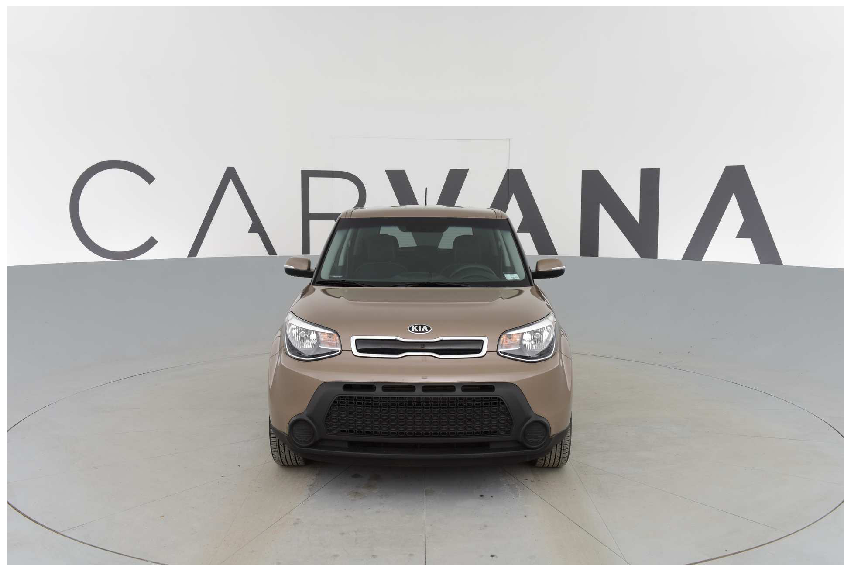

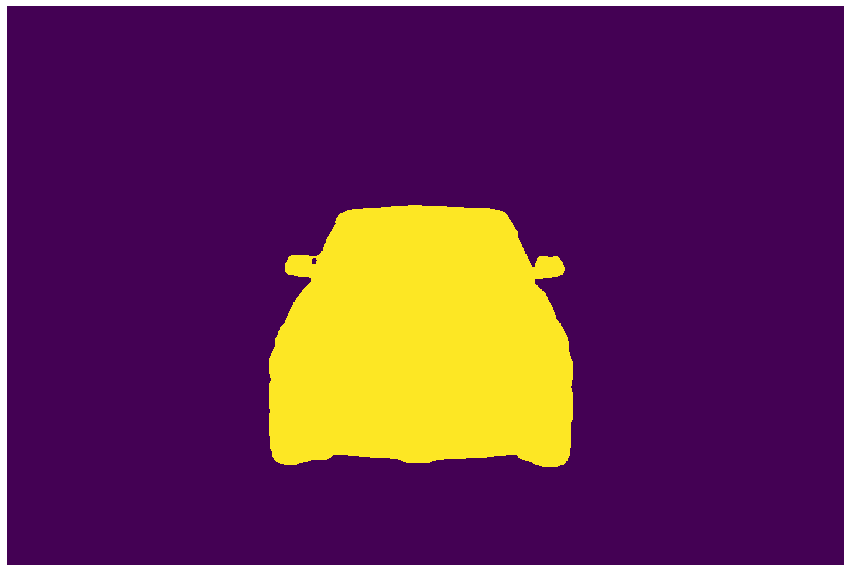

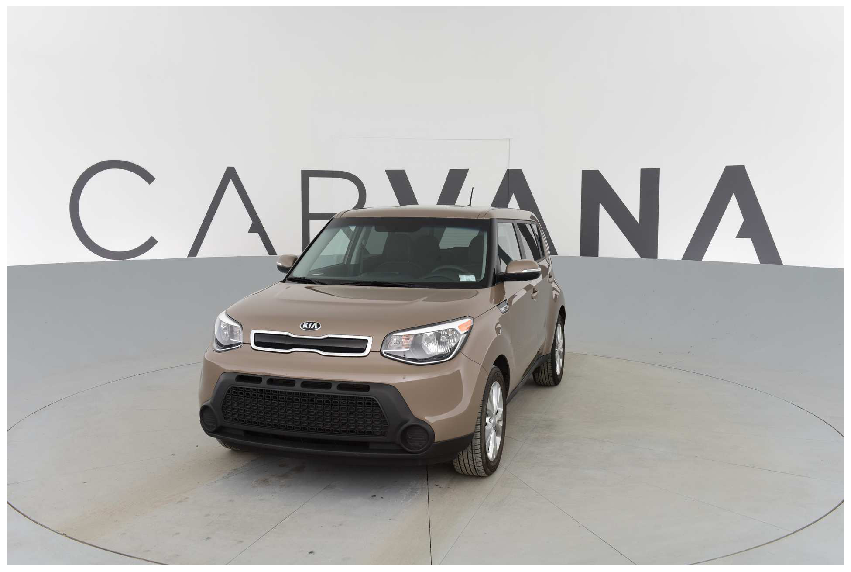

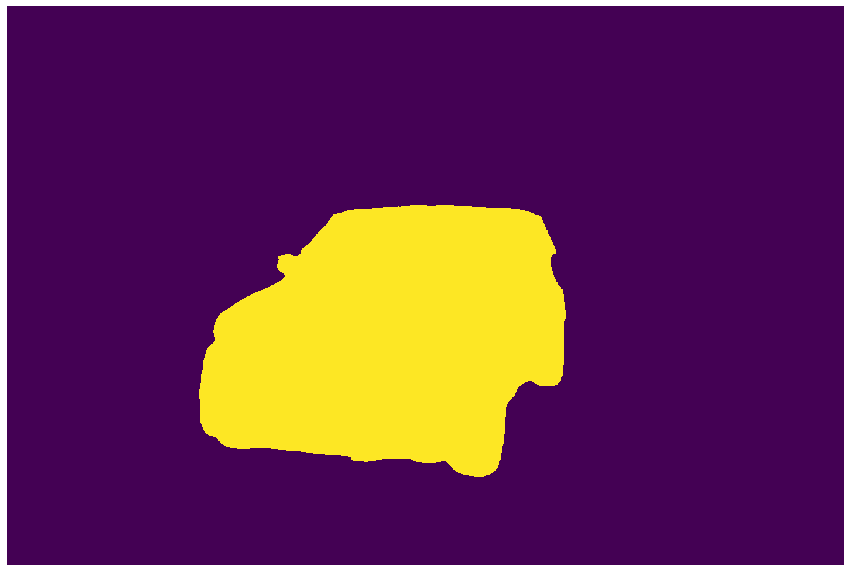

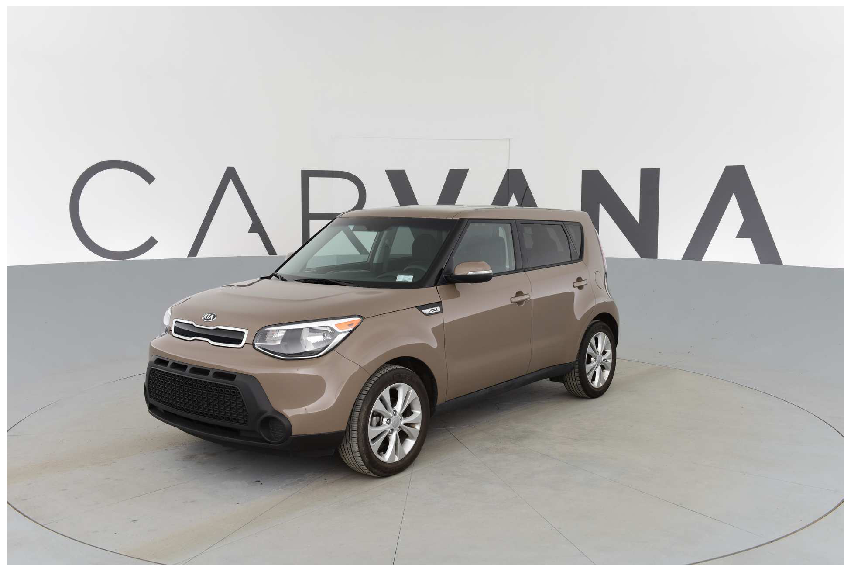

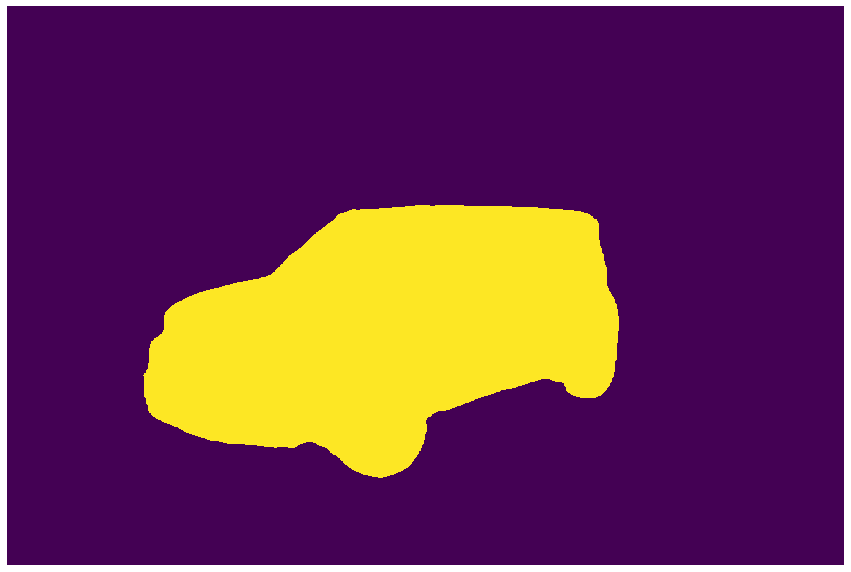

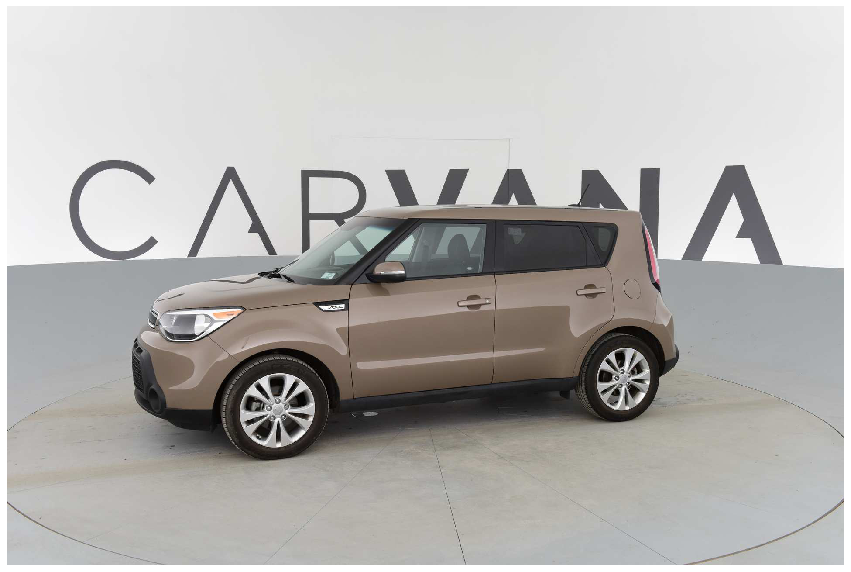

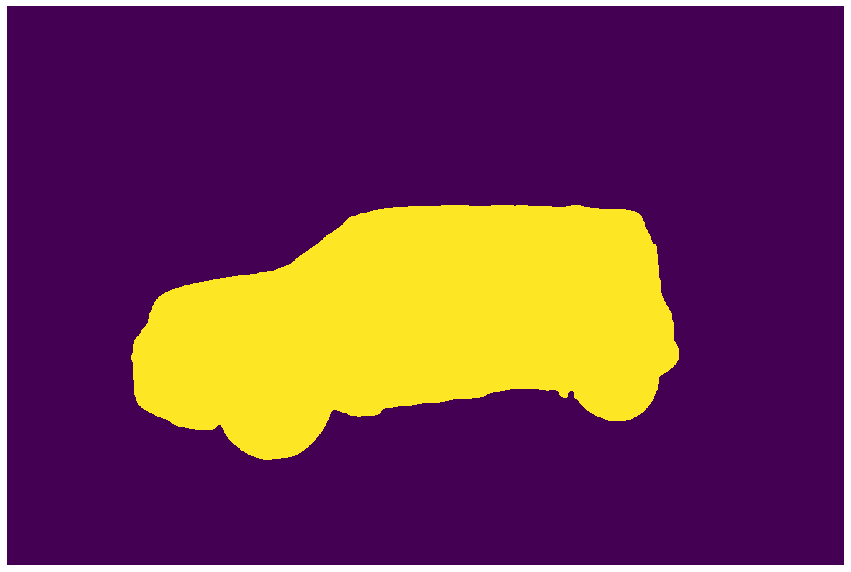

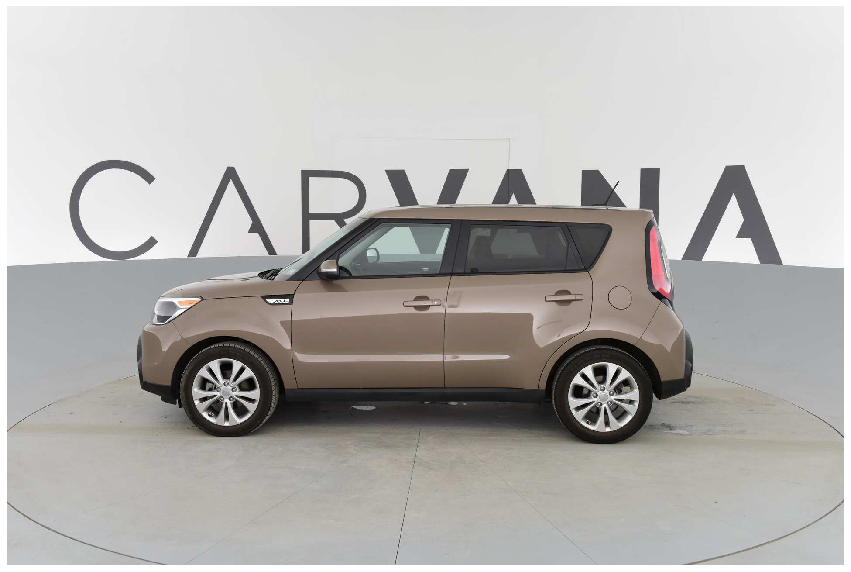

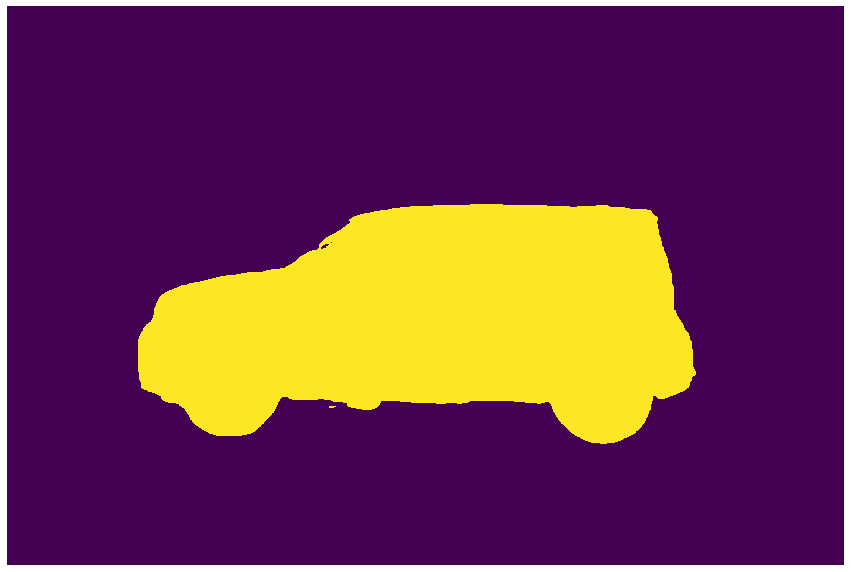

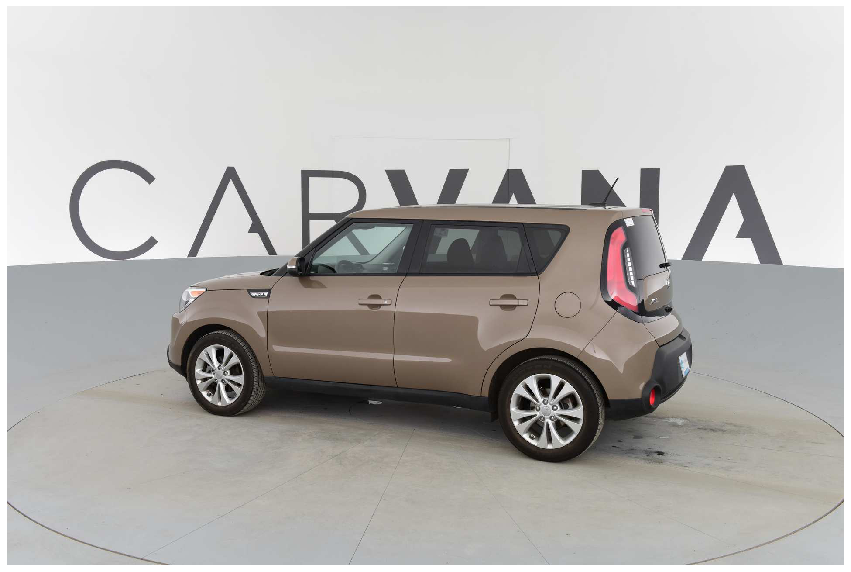

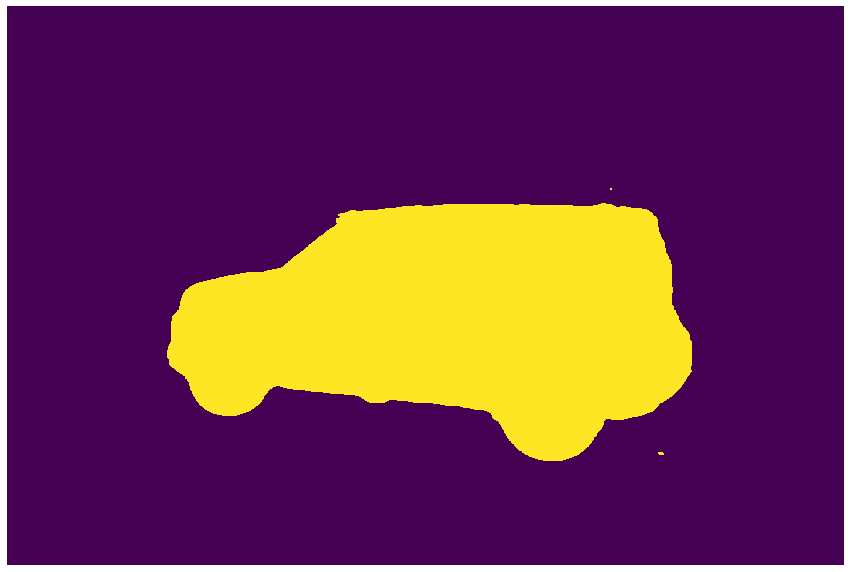

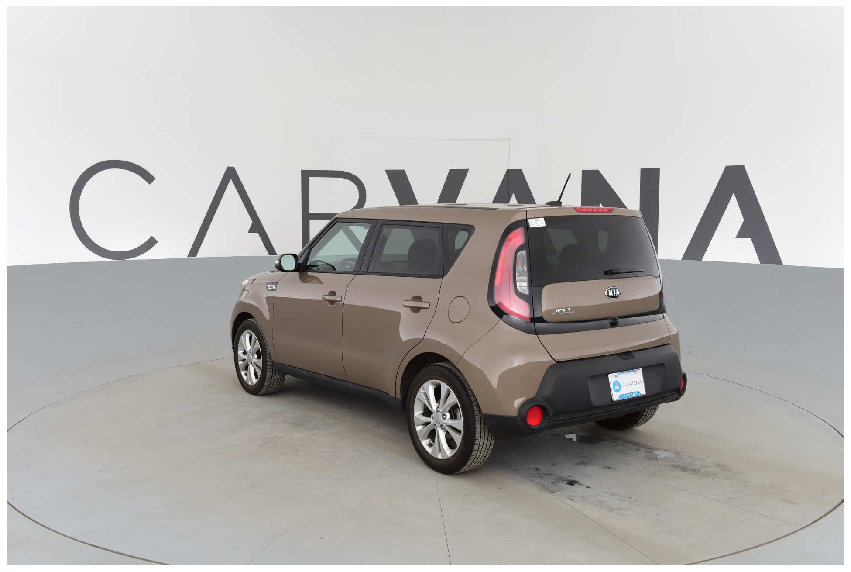

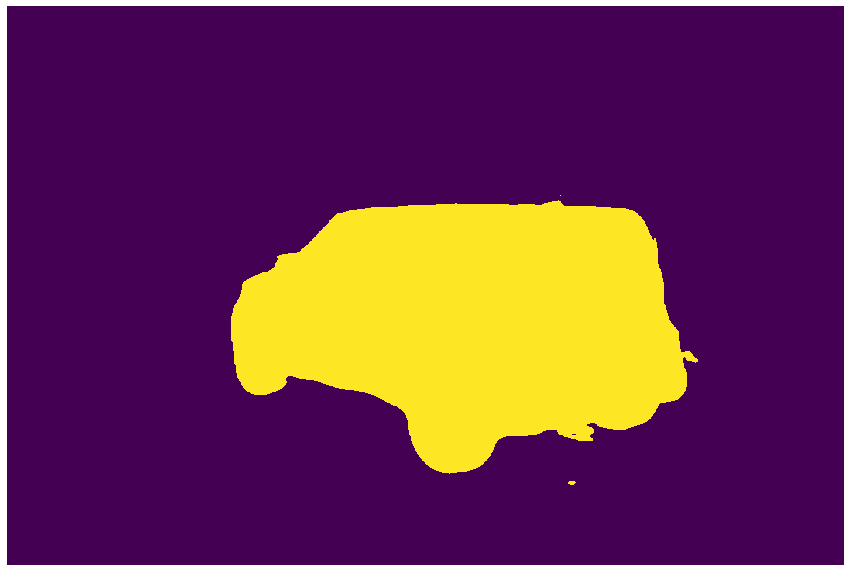

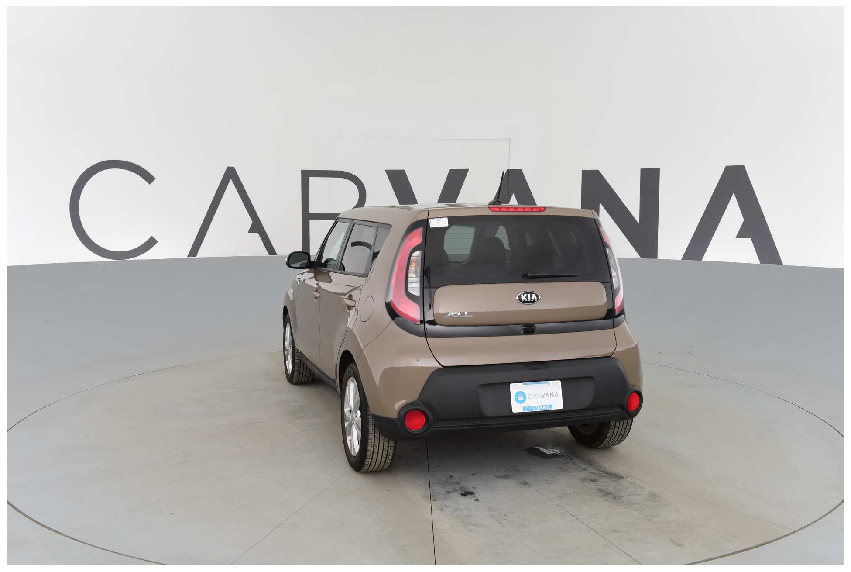

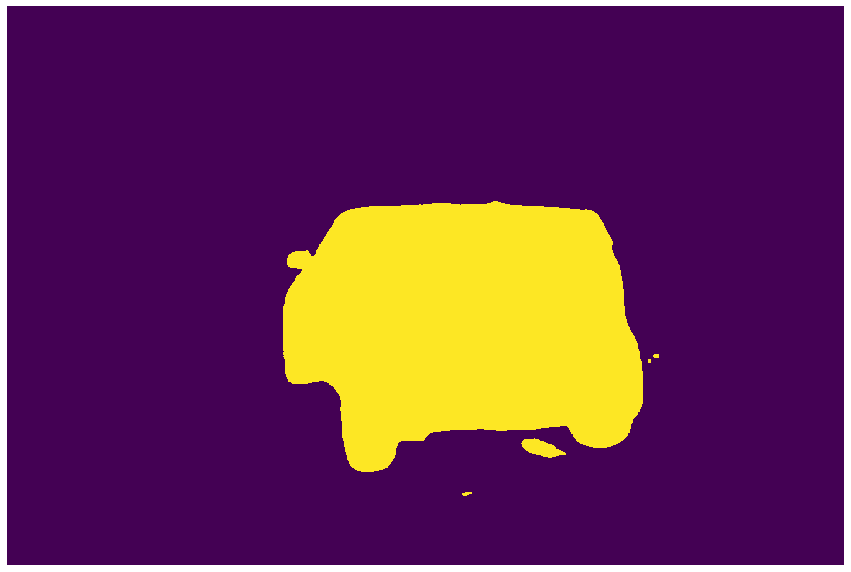

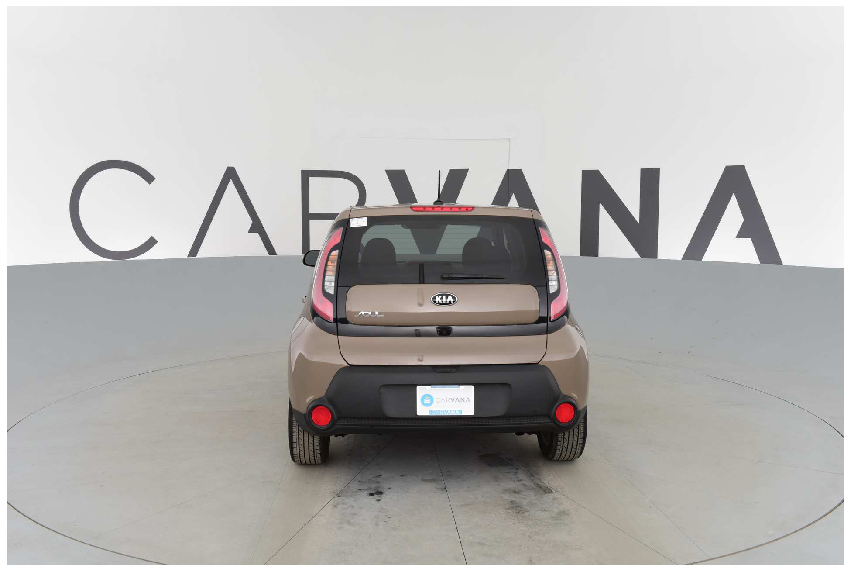

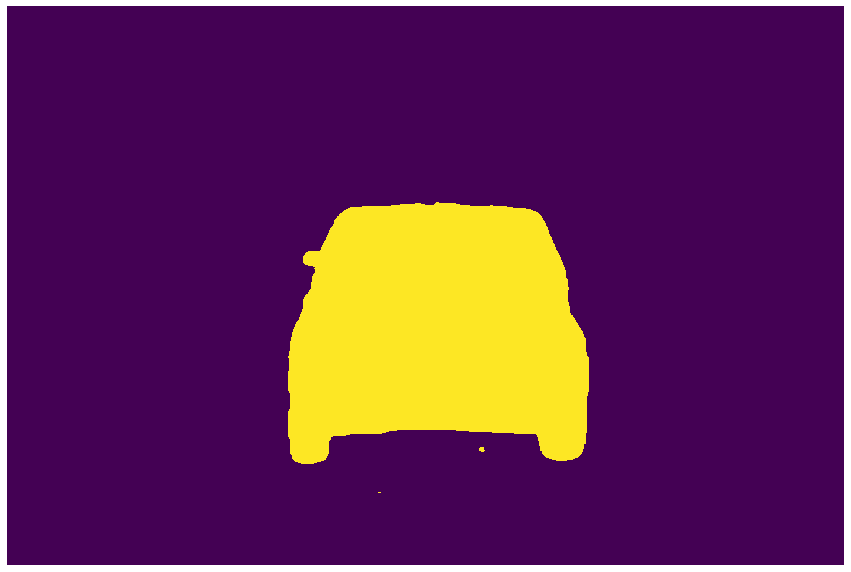

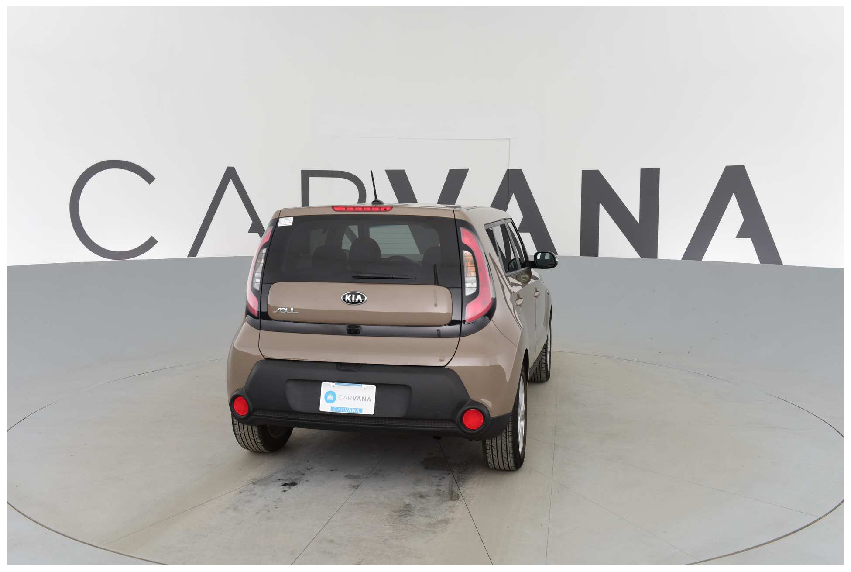

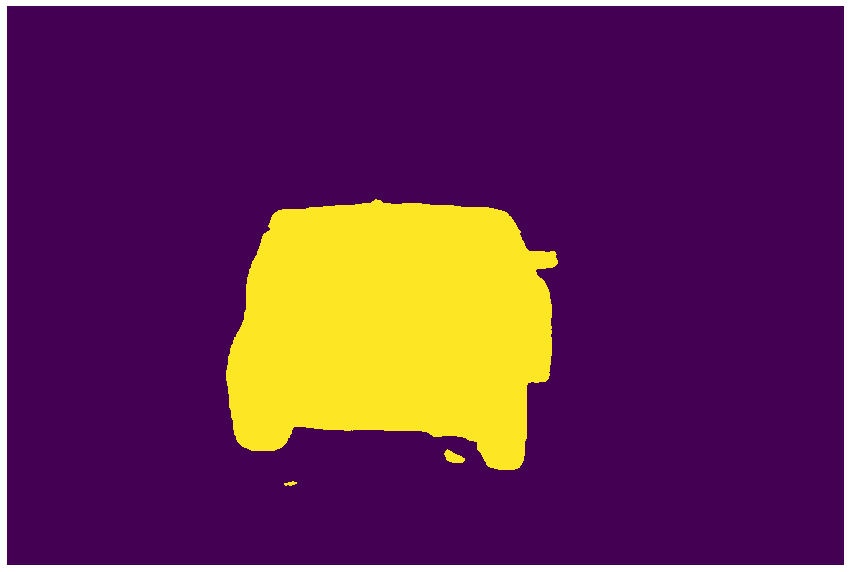

In [20]:
for img_path in os.listdir(TEST_PATH)[32000:32010]:
    #print(img_id, outlier_df[outlier_df.img_id == img_id].values.tolist()[0][2])
    #test_img = get_image(img_id)
    img_id = get_img_id(img_path)
    
    # Plot original image
    actual_img = load_image_disk(img_id, TEST_PATH)
    plt.figure(figsize=(15, 15))
    plt.imshow(actual_img)
    plt.axis('off')
    
    test_img_cv2 = cv2.resize(actual_img, (new_shape[0], new_shape[1]))
    
    # Predict mask
    pred_mask = model.predict(np.expand_dims(test_img_cv2, axis=0))
    
    # Plot predicted mask
    pred_mask = np.squeeze(pred_mask)    
    pred_mask = resize_img(pred_mask, (HEIGHT_ORIG, WIDTH_ORIG))
    pred_mask[pred_mask <= 0.5] = 0
    pred_mask[pred_mask > 0.5] = 1
    
    plt.figure(figsize=(15, 15))
    plt.imshow(pred_mask)
    plt.axis('off')
    plt.show()